## Importando bibliotecas

In [1]:
import pandas as pd
from unidecode import unidecode
import string
import re

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt');
nltk.download('stopwords');
stop_words_en = set(stopwords.words('english'))
stop_words_pt = set(stopwords.words('portuguese'))

import matplotlib.pyplot as plt

import spacy
nlp_en = spacy.load("en_core_web_sm")
nlp_pt = spacy.load("pt_core_news_sm")

from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lendo a base de dados
A base de dados consiste em 3594 ofertas de freelances, com 10 atributos.

In [2]:
df = pd.read_json('gig_finder/freelancer_jobs.json')
print(df.shape)
df.head()

(3594, 10)


,link,title,id,status,price,paid_when,posted_when,deadline,description,tags
0,https://www.br.freelancer.com/projects/website...,aplicacao web atendimento e despacho,ID do Projeto: 37809042,Fechado,$250-750 USD,Pago na entrega,Publicado há 17 dias,há 17 dias,"aplicao web para atendimento, registro do aten...","[NoSQL Couch & Mongo, Java, Node.js, PHP, Python]"
1,https://www.br.freelancer.com/projects/python/...,preciso de um programador,ID do Projeto: #37501673,Encerrado,$250-750 USD,Pago na entrega,Postado há 3 meses,None,[Estou procurando um programador que possa me ...,"[Python, Java, Arquitetura de software, Progra..."
2,https://www.br.freelancer.com/projects/python/...,Correção Gabarito,ID do Projeto: #37505872,Encerrado,$15-25 USD / hora,,Postado há 3 meses,None,"[Olá, estou procurando alguém para desenvolver...","[Python, Machine Learning (ML), OpenCV, Comput..."
3,https://www.br.freelancer.com/projects/cpluspl...,Criar um robô para monitorar salas de cassino ...,ID do Projeto: 37522064,Fechado,$25-50 USD / hour,None,Publicado há 3 meses,há 3 meses,Robô Cassino Roletas AO VIVO Podendo ser em qu...,"[C++ Programming, Python, Script Install, Shel..."
4,https://www.br.freelancer.com/projects/python/...,Criar um robô para monitorar salas de cassino ...,ID do Projeto: 37518087,Fechado,$10-30 USD,Pago na entrega,Publicado há 3 meses,há 3 meses,Robô Cassino Roletas AO VIVO Podendo ser em qu...,"[Python, Shell Script, C++ Programming]"


## Pré-tratamento

In [3]:
def detectar_idioma(text):
    """Como temos texto em inglês e português, precisamos primeiro detectar a lingua."""
    try:
        return detect(text)
    except:
        return "Falhou"
    
def remover_stopwords(text, lang):
    """Remove stopwords de acordo com o idioma."""
    words = word_tokenize(text)
    if lang == "pt":
        filtered_words = [word for word in words if word.lower() not in stop_words_pt]
    elif lang == "en":
        filtered_words = [word for word in words if word.lower() not in stop_words_en]
    else:
        filtered_words = words  # Se não sabemos o idioma, não fazemos nada
    return ' '.join(filtered_words)
    
def lemmatizar(text, lang):
    """Lematizar o texto com o spaCy de acordo com o idioma."""
    if lang == "pt":
        doc = nlp_pt(text)
    elif lang == "en":
        doc = nlp_en(text)
    else:
        return text # Se não sabemos o idioma, não fazemos nada
    return ' '.join([token.lemma_ for token in doc])

# Dependendo do template, a descrição pode ser uma lista ou string
df.loc[:, 'description'] = df['description'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Às vezes o mesmo projeto é publicado inúmeras vezes, então vamos remover duplicatas
df = df.drop_duplicates(subset=['title', 'description'])

# Vamos considerar tanto texto no título quando texto na descrição
df.loc[:, 'normalized'] = df['title'] + ' ' + df['description']

# Lowercase
df.loc[:, 'normalized'] = df['normalized'].str.lower()

# Detectando idioma
df.loc[:, 'language'] = df['normalized'].apply(detectar_idioma)

# Removendo stopwords
df.loc[:, 'normalized'] = df.apply(lambda row: remover_stopwords(row['normalized'], row['language']), axis=1)

# Removendo plural
df.loc[:, 'normalized'] = df.apply(lambda row: lemmatizar(row['normalized'], row['language']), axis=1)

# Removendo pontuação
df.loc[:, 'normalized'] = df['normalized'].str.replace(r'[{}]'.format(string.punctuation), '', regex=True)

# Removendo números
df.loc[:, 'normalized'] = df['normalized'].str.replace(r'[{}]'.format(string.digits), '', regex=True)

# Removendo acentos
df.loc[:, 'normalized'] = df['normalized'].apply(unidecode)

# Visualizando o resultado
df[['normalized', 'language', 'title', 'description']].head()

,normalized,language,title,description
0,aplicacao web atendimento despacho aplicao web...,pt,aplicacao web atendimento e despacho,"aplicao web para atendimento, registro do aten..."
1,preciso programador procurar programador poder...,pt,preciso de um programador,Estou procurando um programador que possa me a...
2,correcao gabarito ola procurar alguem desenvo...,pt,Correção Gabarito,"Olá, estou procurando alguém para desenvolver ..."
3,criar robo monitorar sala cassino online robo ...,pt,Criar um robô para monitorar salas de cassino ...,Robô Cassino Roletas AO VIVO Podendo ser em qu...
5,sistema dashboard interface dever construir ut...,pt,Sistema dashboard,As interfaces devem ser construídas utilizando...


## Encontrando as 20 palavras mais relevantes

Decidi utilizar a soma do TF-IDF de cada palavra entre todos os documentos para selecionar as 20 palavras mais relevantes. 
Poderia expandir o trabalho ao filtrar palavras indesejadas ou que não agregam muito ao resultado.
Mesmo assim, podemos observar as palavras _web_, _scrape_, _api_, podem ser categorizadores relevantes para os freelances que observamos.

In [4]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['normalized'])

# Referência das palavas
feature_names = vectorizer.get_feature_names_out()

# Convertendo a matrix esparsa para umm DataFrame
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Soma de TF-IDF por palavra em todos documentso
word_tfidf_sum = df_tfidf.sum(axis=0)

# Ordena pela soma
sorted_words_tfidf = word_tfidf_sum.sort_values(ascending=False)

# Imprime as palavras mais relevantes
print("Top 20 palavras mais relevantes de acordo com a soma de TF-IDF:")
print(sorted_words_tfidf.head(20))

Top 20 palavras mais relevantes de acordo com a soma de TF-IDF:
python         151.230592
datum          122.324257
experience     110.813576
project        107.001957
need            84.309954
web             81.789875
script          70.650943
user            66.647397
skill           62.858718
developer       62.747311
api             60.648688
code            59.650524
application     58.600939
development     57.906270
work            57.335817
bot             56.164131
website         53.601332
use             53.434324
task            53.173365
scrape          51.239457
dtype: float64


## Histograma

O histograma em escala logaritimica abaixo mostra que uma parte expressiva das palavras são consideradas pouco relevantes.

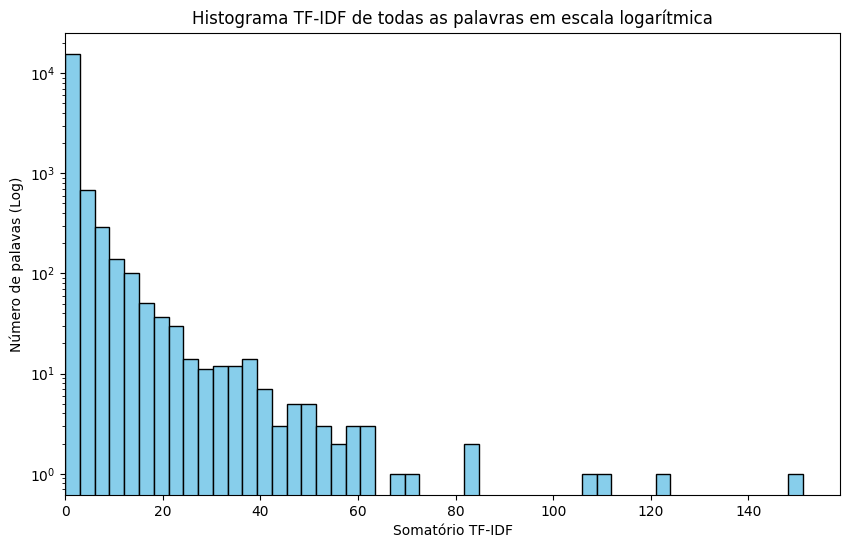

In [5]:
df_tfidf_scores = word_tfidf_sum.reset_index()
df_tfidf_scores.columns = ['word', 'tfidf_sum']

# Imprime o histograma de TF-IDF de todas as palavras em escala logarítmica
plt.figure(figsize=(10, 6))
plt.hist(df_tfidf_scores['tfidf_sum'], bins=50, color='skyblue', edgecolor='black', log=True)
plt.xlabel('Somatório TF-IDF')
plt.ylabel('Número de palavas (Log)')
plt.title('Histograma TF-IDF de todas as palavras em escala logarítmica')
plt.xlim(left=0) 
plt.show()